In [2]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18

unitsvearth = 0 # km/s -> 0 , m/s -> 1

#ctes
mn=0.9315               # Masa nucleon (GeV/c^2)
NA=6.022e23             # Numero de Avogadro
c=299792458             # Velocidad luz (m/)s
hbar = 6.582e-16        # eV*s
sqrtpi=m.sqrt(m.pi)

#Halo DM
rho=0.3                 # Densidad local de materia oscura Gev/c2/cm3
vesc=544                # Velocidad de escape de la galaxia (km/s)

#Velocidad del sol
u1=np.array([ 0.9941, 0.1088, 0.0042])
u2=np.array([-0.0504, 0.4946, -0.8677])
v0=np.array([0,238,0])                      # Velocidad en reposo local standar (km/s)
v0n=np.sqrt(v0.dot(v0))
omega=0.0172                                # Frecuencia angular en d-1 (2pi/365)
vpec=np.array([11.1,12.2,7.3])              # Velocidad peculiar (km/s)
vsun=v0+vpec                                # Velocidad del Sol (km/s)
vorb=29.8                                   # Velocidad orbital de la Tierra (km/s)
timeMax=72.9                                # Dia de la máxima velocidad de la tierra: 2 de junio, empezando desde el 22 de marzo.
timeMin=255.5                               # Dia de la mínima velocidad de la tierra: empezando desde el 22 de marzo.
timeAvg=(timeMax+timeMin)/2.
ene=np.arange(0,100,1)
time=np.arange(0,365,1)




#################
# Funcion de Bessel de primera especie
#################
def j1(x):
    return(m.sin(x)/(x*x)-m.cos(x)/x)

#################
# Velocidad de la tierra, en km/s
#################
def vearth(t): 
    v = vsun + vorb*(m.cos(omega*t)*u1+m.sin(omega*t)*u2)
    return m.sqrt(v.dot(v))
    
#################
# Velocidad minima de la DM para un umbral E (en km/s)
# E en keV
# A: Numero másico
# mW: Masa del Wimp en GeV/c^2
#################
def vmin(E,A,mW): 
    res=E*1e-6*(A*mn+mW)*(A*mn+mW)/(2*A*mn*mW*mW)
    res=np.sqrt(res)*c/1000
    return res

#################
# mean inverse speed function (Función de velocidad inversa media) (en s/km)
# E en keV
# t: Tiempo en dias desde el 22 de marzo
# A: numero masico
# mW: Masa del Wimp en GeV/c^2
#################
def eta(E,t,A,mW):
    x=vmin(E,A,mW)/v0n
    y=vearth(t)/v0n
    z=vesc/v0n
    if(x>(z+y)): 
        return 0
    else:
        N=m.erf(z)-2*z/np.sqrt(np.pi)*m.exp(-z*z)
        if((x>(z-y)) and ((z+y) >= x)):
            return 1/(2*y*v0n*N)*(m.erf(z)-m.erf(x-y)-2/np.sqrt(np.pi)*(z+y-x)*np.exp(-z*z))
        if((x>=(0)) and ((z-y) >= x)):
            return 1/(2*y*v0n*N)*(m.erf(x+y)-m.erf(x-y)-4/np.sqrt(np.pi)*y*np.exp(-z*z))
        
#################
# Factor de Forma
# E en keV
# A: Numero másico
#################
def FF(E,A):
    if E==0:
        E=1e-12
    s=1
    R=1.2*A**(0.3333)
    
    R1=m.sqrt(R*R-5*s*s)
    R1*=1e-6/hbar/c

    q2=2*E*A*mn*1e-6
    x=m.sqrt(q2)*R1
    aux=q2*s*s*1e-6/hbar/c*1e-6/hbar/c
    F2=((3*j1(x)/(x))**2)*m.exp(-aux)
    return F2

#################
# Ritmo diferencial
# E en keV
# A: numero masico
# mW: Masa del Wimp en GeV/c^2
# sigmaSI: Seccion eficaz spin independent en cm^2
#################
def rate(E,t,A,mW,sigmaSI):
    mN=A*mn
    Mdet=NA*mN*1000 # GeV/c2/kg
    mu_n=mW*mn/(mW+mn)
    retval=Mdet*rho/2./mW*A*A/mu_n/mu_n*sigmaSI*c*c
    retval*=8.64e-3 # to convert to counts/kg/keV/d
    retval*=365 # convert to counts/kg/keV/y
    retval*=FF(E,A)
    retval*=eta(E,t,A,mW)
    return retval

#########################
#########################
# Ritmo total, integrado entre Ei y Ef (en c/kg/y)
# Ei, Ef: Energias inicial y final en keV
# t: tiempo en dias desde el 22 de marzo
# A: numero masico
# mW: Masa del Wimp en GeV/c^2
# sigmaSI: Seccion eficaz spin independent en cm^2
def totalRate(Ei,Ef,t,A,mW,sigmaSI):
  ene=np.arange(Ei,Ef,0.1)
  rates=np.array([rate(e,t,A,mW,sigmaSI) for e in ene])
  return rates.sum()*0.1

#########################
#########################
# Ritmo en funcon del tiempo
# Ei, Ef: Energias inicial y final en keV
# t: tiempo en dias desde el 22 de marzo
# A: numero masico
# mW: Masa del Wimp en GeV/c^2
# sigmaSI: Seccion eficaz spin independent en cm^2
def ratevsTime(Ei,Ef,A,mW,sigmaSI):
    dias = np.arange(0,365)
    ritmos_dias=([totalRate(Ei,Ef,t,A,mW,sigmaSI) for t in dias])
    return ritmos_dias
    
# FUNCIONES ESPECIFICAS PARA NAI

#########################
#########################
# Ritmo en funcon del tiempo
# Ei, Ef: Energias inicial y final en keV
# t: tiempo en dias desde el 22 de marzo
# A: numero masico
# mW: Masa del Wimp en GeV/c^2
# sigmaSI: Seccion eficaz spin independent en cm^2
def ratevsTimeNaI(Ei,Ef,mW,sigmaSI):
    dias = np.arange(0,365)
    ritmos_dias=([totalRateNaI(Ei,Ef,t,mW,sigmaSI) for t in dias])
    return ritmos_dias
       
#########################
#########################
# Ritmo total, integrado entre Ei y Ef (en c/kg/y)
# Ei, Ef: Energias inicial y final en keV
# t: tiempo en dias desde el 22 de marzo
# A: numero masico
# mW: Masa del Wimp en GeV/c^2
# sigmaSI: Seccion eficaz spin independent en cm^2
def totalRateNaI(Ei,Ef,t,mW,sigmaSI):
  ene=np.arange(Ei,Ef,0.1)
  rates=np.array([RateNaI(e,t,mW,sigmaSI) for e in ene])
  return rates.sum()*0.1

#########################
#########################
# Ritmo diferencial
# E en keV
# t: tiempo en dias desde el 22 de marzo
# mW: Masa del Wimp en GeV/c^2
# sigmaSI: Seccion eficaz spin independent en cm^2
def RateNaI(E,t,mW,sigmaSI):
    ratesNa=rate(E,t,23,mW,sigmaSI)
    ratesI=rate(E,t,127,mW,sigmaSI)
    return (23.*ratesNa+127.*ratesI)/(23.+127.)


#FACTOR QUENCHING

#   Devuelve el factor quenching del NaI evaluado en electron-equivalent energy ee
#   Parametros
# ee : float o array-like de Electron-equivalent energy.
# Devuelve: float or np.ndarray
# Quenching factor QF(ee), interpolado linealmente en (x=ER*QF, y=QF)
# Construido para ER in [1, 100] with N=200 points.
# From modified Lindhard Fit of Na QF data (Tamara's thesis)
# k = 0.072, alpha = 0.007
# epsilon = alpha * ER
# g(ER)=3*pow(epsilon, 0.15) + 0.7*pow(epsilon,0.6) + epsilon
# QF(ER)=k*g(ER)/(1+k*g(ER))
# Eee=ER*QF(ER)

def getQFNa(ee, k=0.072, alpha=0.007, N=200, ER_min=1.0, ER_max=100.0):
    # calculate QF(ER) for interval ER_min, ER_max
    ER = np.linspace(ER_min, ER_max, N)
    epsilon = alpha * ER
    g = 3.0 * epsilon**0.15 + 0.7 * epsilon**0.6 + epsilon
    qf = (k * g) / (1.0 + k * g)

    # Graph: x = ER * qf (== ee), y = qf
    x = ER * qf
    y = qf

    # Interpolate y at the provided ee values.
    # For values outside the tabulated range, clamp to the nearest endpoint
    ee_arr = np.atleast_1d(ee).astype(float)
    y_interp = np.interp(ee_arr, x, y, left=y[0], right=y[-1])

    return y_interp[0] if np.isscalar(ee) else y_interp

def getQFI(ee, p0=0.03, p1=0.0006, limit=80.0, N=200, ER_min=1.0, ER_max=100.0):
    # calculate QF(ER) for interval ER_min, ER_max
    ER = np.linspace(ER_min, ER_max, N)

    # Piecewise-linear QF(ER)
    qf = p0 + p1 * np.minimum(ER, limit)

    # Graph x = ER * QF(ER), y = QF(ER)
    x = ER * qf
    y = qf

    # Interpolate y at ee; clamp outside domain to the nearest endpoint
    ee_arr = np.atleast_1d(ee).astype(float)
    y_interp = np.interp(ee_arr, x, y, left=y[0], right=y[-1])

    return y_interp[0] if np.isscalar(ee) else y_interp

#################
# Ritmo diferencial
# E en keV
# A: numero masico
# mW: Masa del Wimp en GeV/c^2
# sigmaSI: Seccion eficaz spin independent en cm^2
#################
def rate_ee(Eee,t,A,mW,sigmaSI,Q=1):
    E=Eee/Q
    mN=A*mn
    Mdet=NA*mN*1000 # GeV/c2/kg
    mu_n=mW*mn/(mW+mn)
    retval=Mdet*rho/2./mW*A*A/mu_n/mu_n*sigmaSI*c*c
    retval*=8.64e-3 # to convert to counts/kg/keV/d
    retval*=365 # convert to counts/kg/keV/y
    retval*=FF(E,A)
    retval*=eta(E,t,A,mW)
    retval/=Q
    return retval

#########################
#########################
# differential rate in NaI detector (in c/kevee/kg/y) 
# E: in keVee
# t: time in days since March 22
# mW: Wimp mass in GeV/c^2
# sigmaSI: SI cross section in cm^2
# QNa is the quenching factor at energy Eee(keVee) for Na
# QI is the quenching factor at energy Eee(keVee) for I
def rateNaI_ee(Eee,t,mW,sigmaSI, QNa=1, QI=1):
  # convert Eee to keV_NR
  rateNa = rate_ee(Eee,t,23,mW,sigmaSI,QNa)
  rateI = rate_ee(Eee,t,127,mW,sigmaSI,QI)
 
  return (rateNa*23.+rateI*127.)/(23.+127.)

#########################
#########################
# total rate, integrated between Eiee and Efee (in c/kg/y)
# Eiee, Efee: Initial and final energies in keVee
# t: time in days since March 22
# A: mass number
# mW: Wimp mass in GeV/c^2
# sigmaSI: SI cross section in cm^2
def totalRate_NaI(Eiee,Efee,t,mW,sigmaSI):
  energy_ee = np.arange(Eiee,Efee,0.1)
  qfNa = getQFNa(energy_ee)
  qfI = getQFI(energy_ee)
  rates = np.array([
        rateNaI_ee(e, t, mW, sigmaSI, qna, qi)
        for e, qna, qi in zip(energy_ee, qfNa, qfI)
    ])

  return rates.sum()*0.1


Ejercicio 1

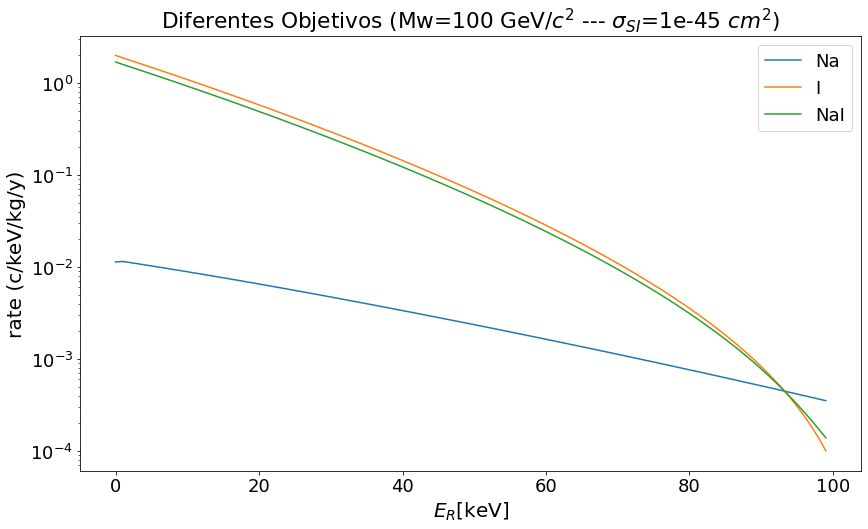

In [2]:

timeMax=72.9 
timeMin=255.5 
timeAvg=(timeMax+timeMin)/2.

mW=100 #masa wimp (geV/c^2)
si=1e-45 #seccion eficaz SI(cm^-2)
ene=np.arange(0,100,1)


rateNa=np.array([rate(e,timeAvg,23,mW,si) for e in ene])
rateI=np.array([rate(e,timeAvg,127,mW,si) for e in ene])
rate_NaI=np.array([RateNaI(e,timeAvg,mW,si) for e in ene])

plt.figure(figsize=(14, 8))
ax = plt.subplot()
ax.plot(ene,rateNa, label = "Na")
ax.plot(ene,rateI, label = "I")
ax.plot(ene,rate_NaI, label = "NaI")
ax.set_title('Diferentes Objetivos (Mw=' + str(np.round(mW)) + ' GeV/$c^2$ --- $\sigma_{SI}$=' + str(si) + ' $cm^2$)')
ax.set_ylabel('rate (c/keV/kg/y)',fontsize=20)
ax.set_xlabel('$E_{R}$'+ '[keV]',fontsize=20)
ax.legend()
ax.set_yscale("log")

Ejercicio 2

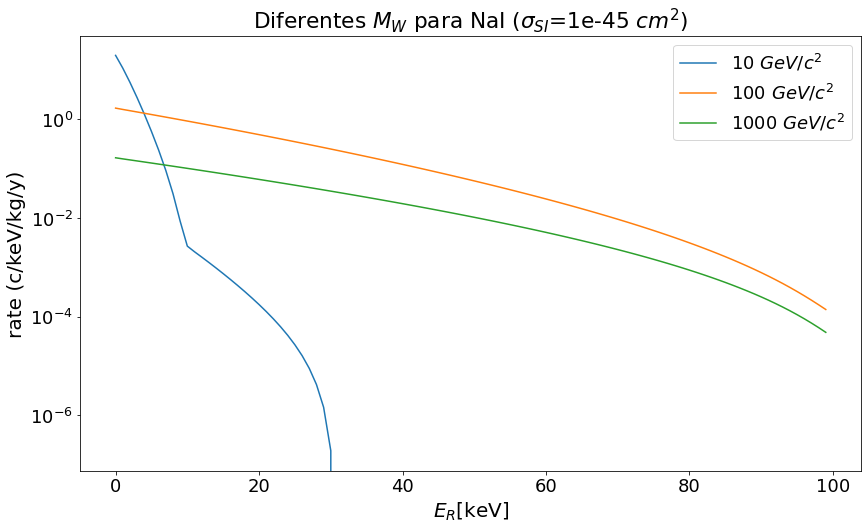

In [3]:

timeMax=72.9 
timeMin=255.5 
timeAvg=(timeMax+timeMin)/2.


si=1e-45 #seccion eficaz SI(cm^-2)
ene=np.arange(0,100,1)


rateAr10=np.array([RateNaI(e,timeAvg,10,si) for e in ene])
rateAr100=np.array([RateNaI(e,timeAvg,100,si) for e in ene])
rateAr1000=np.array([RateNaI(e,timeAvg,1000,si) for e in ene])

plt.figure(figsize=(14, 8))
ax = plt.subplot()
ax.plot(ene,rateAr10, label = "10 $GeV/c^2$")
ax.plot(ene,rateAr100, label = "100 $GeV/c^2$")
ax.plot(ene,rateAr1000, label = "1000 $GeV/c^2$")
ax.set_title('Diferentes $M_W$ para NaI ($\sigma_{SI}$=' + str(si) + ' $cm^2$)')
ax.set_ylabel('rate (c/keV/kg/y)',fontsize=20)
ax.set_xlabel('$E_{R}$'+ '[keV]',fontsize=20)
ax.legend()
ax.set_yscale("log")


Ejercicio 3

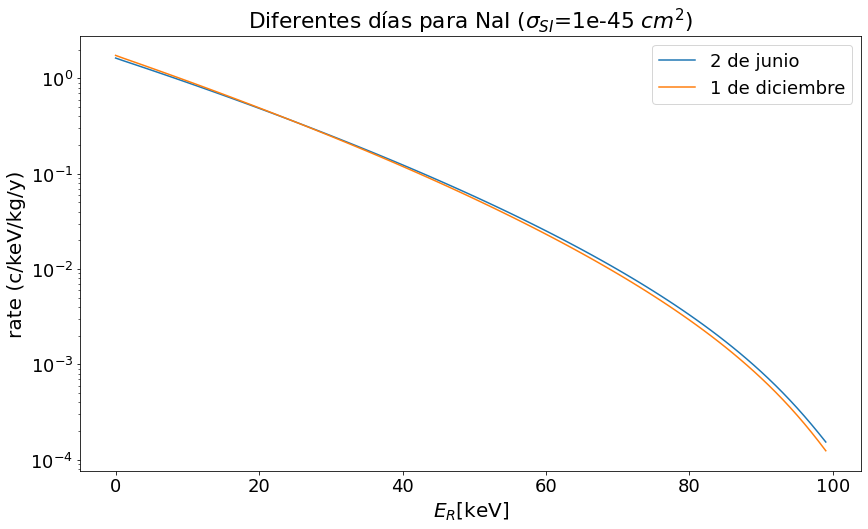

In [4]:

timeMax=72.9 
timeMin=255.5 

mW=100 #masa wimp (geV/c^2)
si=1e-45 #seccion eficaz SI(cm^-2)
ene=np.arange(0,100,1)


rateArtmax=np.array([RateNaI(e,timeMax,mW,si) for e in ene])
rateArtmin=np.array([RateNaI(e,timeMin,mW,si) for e in ene])

plt.figure(figsize=(14, 8))
ax = plt.subplot()
ax.plot(ene,rateArtmax, label = "2 de junio")
ax.plot(ene,rateArtmin, label = "1 de diciembre")

ax.set_title('Diferentes días para NaI ($\sigma_{SI}$=' + str(si) + ' $cm^2$)')
ax.set_ylabel('rate (c/keV/kg/y)',fontsize=20)
ax.set_xlabel('$E_{R}$'+ '[keV]',fontsize=20)
ax.legend()
ax.set_yscale("log")



R_max = 3.39053e+05
R_min = 333924.0
R_0 = 336522.0
t_max = 256
Error = 0.00979


Text(0.5, 0, 'time (days since March 22)')

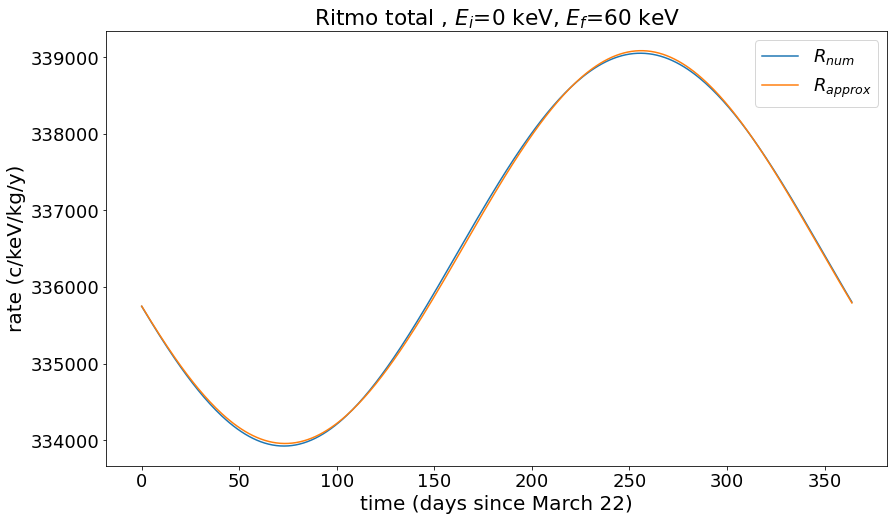

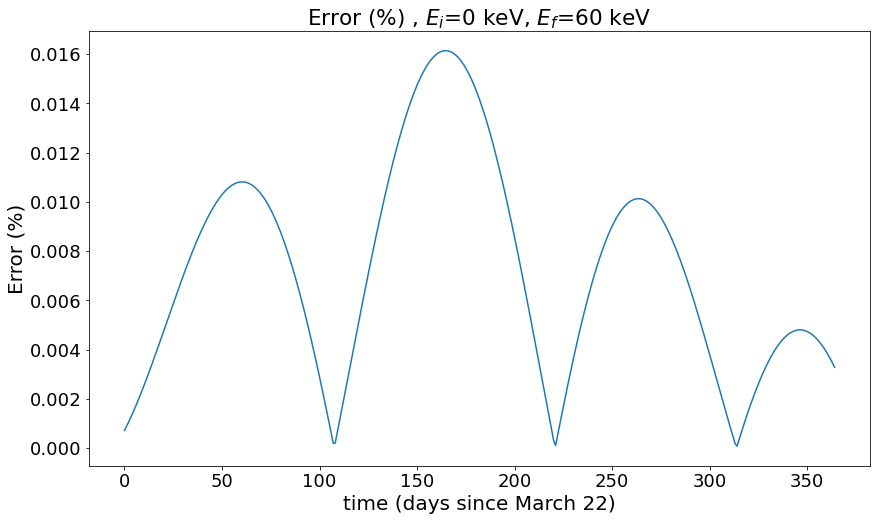

In [5]:

Ei=0
Ef=60

mW=70
si=1e-41 #seccion eficaz SI(cm^-2)
ritmosvstiempos=ratevsTimeNaI(Ei,Ef,mW,si)
R_max=np.max(ritmosvstiempos)
print('R_max = '+str(np.round(R_max)))
R_min=np.min(ritmosvstiempos)
print('R_min = '+str(np.round(R_min)))
R_0=np.mean(ritmosvstiempos)
print('R_0 = '+str(np.round(R_0)))
t_max=np.argmax(ritmosvstiempos)
print('t_max = '+str(t_max))

R_mod=0.5*(R_max-R_min)
omega=2*np.pi/365.

dias = np.arange(0,365)

rapprox=([(R_0+R_mod*np.cos(omega*(t-t_max))) for t in dias])

plt.figure(figsize=(14, 8))
ax = plt.subplot()
ax.plot(dias,ritmosvstiempos, label = "$R_{num}$")
ax.plot(dias,rapprox, label = "$R_{approx}$")
ax.set_title('Ritmo total , $E_i$='+str(Ei)+' keV, $E_f$='+str(Ef)+' keV')
ax.set_ylabel('rate (c/keV/kg/y)',fontsize=20)
ax.set_xlabel('time (days since March 22)',fontsize=20)
ax.legend()


err=([np.abs(((1-rapprox[t]/ritmosvstiempos[t]))*100) for t in dias])
print('Error = '+str(np.round(err[t_max],5)))

plt.figure(figsize=(14, 8))
ax = plt.subplot()
ax.plot(dias,err, label = "$R_{num}$")
ax.set_title('Error (%) , $E_i$='+str(Ei)+' keV, $E_f$='+str(Ef)+' keV')
ax.set_ylabel('Error (%)',fontsize=20)
ax.set_xlabel('time (days since March 22)',fontsize=20)
#ax.set_yscale("log")



R_max = 1.61124e+05
R_min = 158160.0
R_0 = 159716.0
t_max = 73
Error = 0.04539


Text(0.5, 0, 'time (days since March 22)')

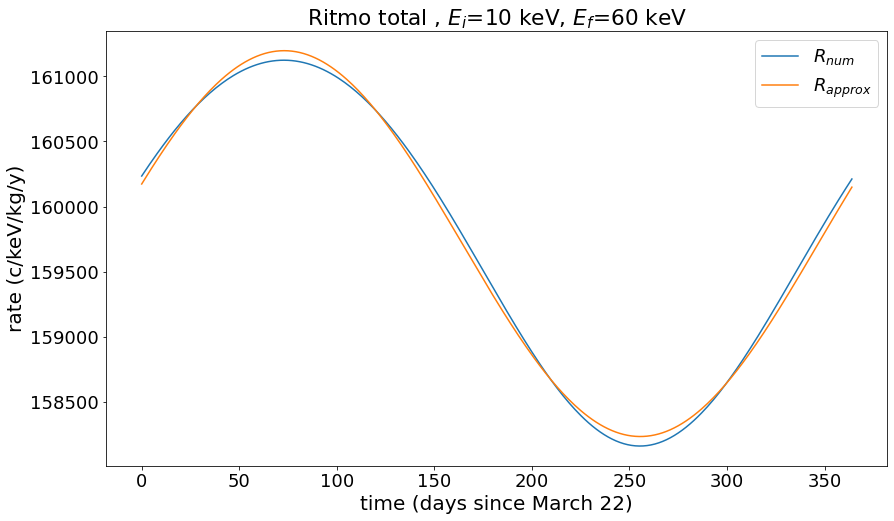

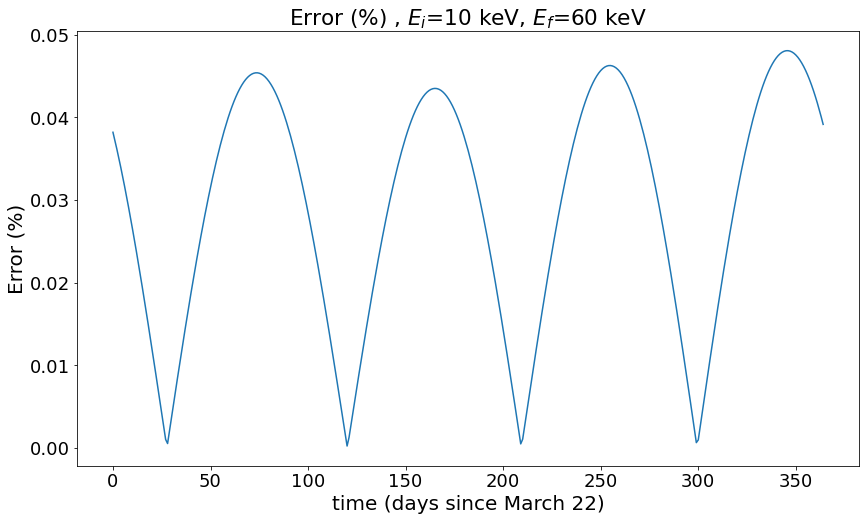

In [6]:
Ei=10
Ef=60

mW=70
si=1e-41 #seccion eficaz SI(cm^-2)
ritmosvstiempos=ratevsTimeNaI(Ei,Ef,mW,si)
R_max=np.max(ritmosvstiempos)
print('R_max = '+str(np.round(R_max)))
R_min=np.min(ritmosvstiempos)
print('R_min = '+str(np.round(R_min)))
R_0=np.mean(ritmosvstiempos)
print('R_0 = '+str(np.round(R_0)))
t_max=np.argmax(ritmosvstiempos)
print('t_max = '+str(t_max))

R_mod=0.5*(R_max-R_min)
omega=2*np.pi/365.

dias = np.arange(0,365)

rapprox=([(R_0+R_mod*np.cos(omega*(t-t_max))) for t in dias])

plt.figure(figsize=(14, 8))
ax = plt.subplot()
ax.plot(dias,ritmosvstiempos, label = "$R_{num}$")
ax.plot(dias,rapprox, label = "$R_{approx}$")
ax.set_title('Ritmo total , $E_i$='+str(Ei)+' keV, $E_f$='+str(Ef)+' keV')
ax.set_ylabel('rate (c/keV/kg/y)',fontsize=20)
ax.set_xlabel('time (days since March 22)',fontsize=20)
ax.legend()


err=([np.abs(((1-rapprox[t]/ritmosvstiempos[t]))*100) for t in dias])
print('Error = '+str(np.round(err[t_max],5)))

plt.figure(figsize=(14, 8))
ax = plt.subplot()
ax.plot(dias,err, label = "$R_{num}$")
ax.set_title('Error (%) , $E_i$='+str(Ei)+' keV, $E_f$='+str(Ef)+' keV')
ax.set_ylabel('Error (%)',fontsize=20)
ax.set_xlabel('time (days since March 22)',fontsize=20)
#ax.set_yscale("log")



Text(0.5, 0, '$\\sigma_{SI}$ ($cm^2$)')

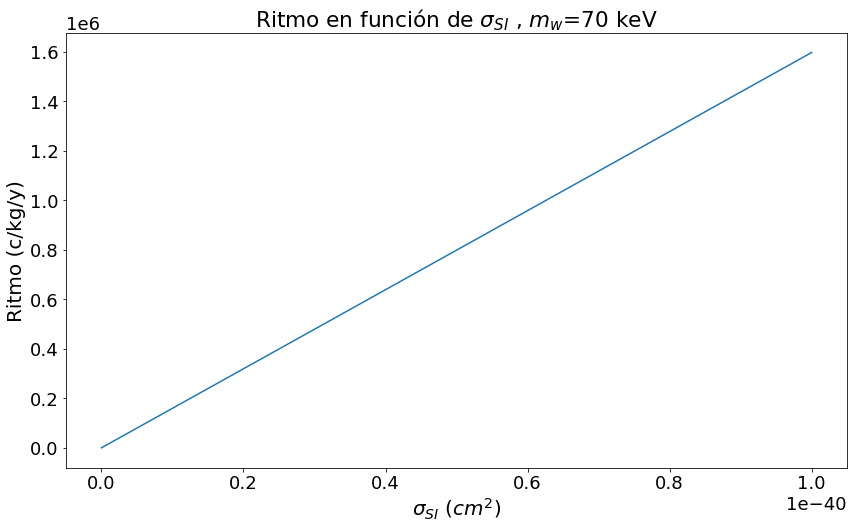

In [7]:
#Calculamos función Ritmo vs Seccion Eficaz

timeMax=72.9 
timeMin=255.5 
timeAvg=(timeMax+timeMin)/2.

mW=70 

SIs= np.linspace(1e-40,1e-48,100)

R=np.array([totalRateNaI(10,60,timeAvg,mW,s) for s in SIs])


plt.figure(figsize=(14, 8))
ax = plt.subplot()
ax.plot(SIs,R, label = "$R_{num}$")
ax.set_title('Ritmo en función de $\sigma_{SI}$ , $m_w$='+str(mW)+' keV')
ax.set_ylabel('Ritmo (c/kg/y)',fontsize=20)
ax.set_xlabel('$\sigma_{SI}$ ($cm^2$)',fontsize=20)
#ax.set_yscale("log")


Text(0.5, 0, '$m_w$ (GeV)')

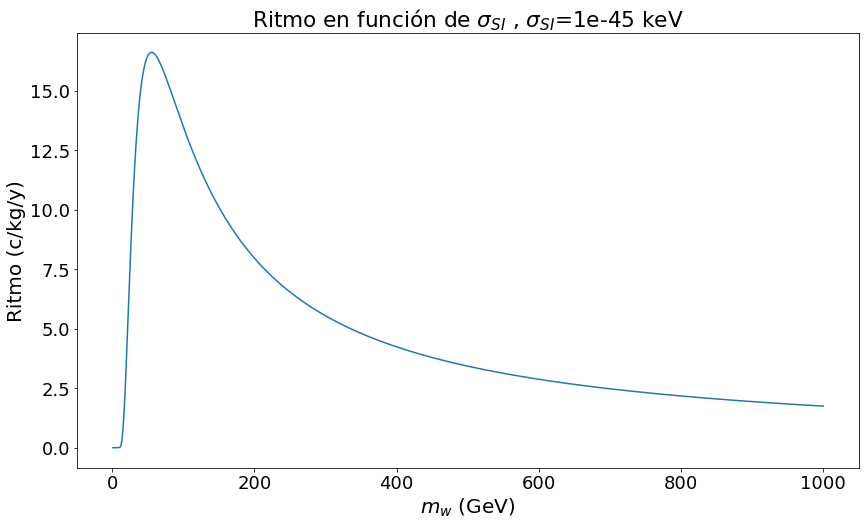

In [8]:
#Calculamos función Ritmo vs Masa Wimp

timeMax=72.9 
timeMin=255.5 
timeAvg=(timeMax+timeMin)/2.

sigma_si=1e-45

mWs= np.linspace(1,1000,1000)

R=np.array([totalRateNaI(10,60,timeAvg,m,sigma_si) for m in mWs])


plt.figure(figsize=(14, 8))
ax = plt.subplot()
ax.plot(mWs,R, label = "$R_{num}$")
ax.set_title('Ritmo en función de $\sigma_{SI}$ , $\sigma_{SI}$='+str(sigma_si)+' keV')
ax.set_ylabel('Ritmo (c/kg/y)',fontsize=20)
ax.set_xlabel('$m_w$ (GeV)',fontsize=20)
#ax.set_yscale("log")


In [7]:
import uproot
file = uproot.open("BEhistos_year123456.root")
file.keys()

['hbea_123456y_D0;1',
 'hbea_123456y_D1;1',
 'hbea_123456y_D2;1',
 'hbea_123456y_D3;1',
 'hbea_123456y_D4;1',
 'hbea_123456y_D5;1',
 'hbea_123456y_D6;1',
 'hbea_123456y_D7;1',
 'hbea_123456y_D8;1',
 'hbea_123456y;1']

In [ ]:
longitud=290
es=np.arange(1,30,0.1)
datos=np.zeros((19,longitud))
for i in range (9):
    datos[2*i+1]=file["hbea_123456y_D"+str(i)].values()
    datos[2*i+2]=file["hbea_123456y_D"+str(i)].errors()
    print(i)
datos[0]=es
#np.savetxt("Exposicion_exp.csv",datos)   
    

0
1
2
3
4
5
6
7
8


In [11]:
es=np.arange(1,30,0.1)
print(len(es))

290


In [9]:
file["hbea_123456y_D0"].all_members

{'@fUniqueID': 0,
 '@fBits': 50332168,
 'fName': 'hbe0_year1_year6',
 'fTitle': '',
 'fLineColor': 600,
 'fLineStyle': 1,
 'fLineWidth': 2,
 'fFillColor': 0,
 'fFillStyle': 1001,
 'fMarkerColor': 600,
 'fMarkerStyle': 20,
 'fMarkerSize': 0.6000000238418579,
 'fNcells': 292,
 'fXaxis': <TAxis (version 10) at 0x7559107b9d60>,
 'fYaxis': <TAxis (version 10) at 0x755928464610>,
 'fZaxis': <TAxis (version 10) at 0x755928464520>,
 'fBarOffset': 0,
 'fBarWidth': 1000,
 'fEntries': 1802461.691594407,
 'fTsumw': 751.0752220746325,
 'fTsumw2': 0.3131543994404597,
 'fTsumwx': 9198.823684529332,
 'fTsumwx2': 166183.86047925722,
 'fMaximum': 16.0,
 'fMinimum': 0.0,
 'fNormFactor': 0.0,
 'fContour': <TArrayD [] at 0x755910732d60>,
 'fSumw2': <TArrayD [0, 0.0131034, 0.00679434, ..., 0.000616966, 0.000634182, 0] at 0x755910732580>,
 'fOption': <TString '' at 0x755910739350>,
 'fFunctions': <TList of 0 items at 0x755910732f10>,
 'fBufferSize': 0,
 'fBuffer': array([], dtype=float64),
 'fBinStatErrOpt':

In [29]:
file["hbea_123456y_D0"].axis().edges()

array([ 1. ,  1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,
        2.1,  2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,
        3.2,  3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,
        4.3,  4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,
        5.4,  5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,
        6.5,  6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,
        7.6,  7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,
        8.7,  8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,
        9.8,  9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8,
       10.9, 11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9,
       12. , 12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13. ,
       13.1, 13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14. , 14.1,
       14.2, 14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15. , 15.1, 15.2,
       15.3, 15.4, 15.5, 15.6, 15.7, 15.8, 15.9, 16

In [30]:
file["hbea_123456y_D0"].values()

array([7.7058105, 7.311093 , 6.7740903, 6.026569 , 5.9330454, 5.458445 ,
       5.353915 , 5.0994816, 5.0174937, 5.035382 , 4.987608 , 4.839416 ,
       4.796341 , 5.030872 , 4.986949 , 5.070045 , 5.2279673, 5.4516573,
       5.517425 , 5.688737 , 5.6556563, 5.677316 , 5.6572313, 5.5827994,
       5.4075494, 5.2673492, 4.9837985, 4.815637 , 4.549021 , 4.4147277,
       4.19852  , 4.0622582, 3.8799195, 3.850383 , 3.7479897, 3.7728004,
       3.6365385, 3.595975 , 3.5904615, 3.5888863, 3.5073655, 3.5109098,
       3.4415975, 3.415999 , 3.4254508, 3.3317215, 3.4333272, 3.415999 ,
       3.3998523, 3.396308 , 3.347868 , 3.2943084, 3.387644 , 3.4199371,
       3.2880073, 3.2769804, 3.2950962, 3.2549264, 3.2320848, 3.2037299,
       3.229722 , 3.1915214, 3.1489887, 3.132842 , 3.170255 , 3.1060622,
       3.1320543, 3.0973983, 3.062742 , 3.0639236, 3.0658927, 3.0706184,
       3.0135145, 2.990279 , 3.0158775, 3.0056381, 2.992248 , 2.9906728,
       2.9241173, 2.924511 , 2.8993065, 2.8752835, 

In [ ]:
a=file["hbea_123456y_D0"].to_numpy()


Generar array con los tiempos de exposicion en dias

In [ ]:
exposiciones=np.zeros(9) #dias
exposiciones[0]=2031.38
exposiciones[1]=2033.20
exposiciones[2]=2029.52
exposiciones[3]=2022.55
exposiciones[4]=2033.01
exposiciones[5]=2030.18
exposiciones[6]=2032.27 
exposiciones[7]=2031.02
exposiciones[8]=2020.29

#np.savetxt("exposiciones.csv",exposiciones)
